# Automatic Red Eye Removal

![Automatic Red Eye Removal](data/images/automatic-red-eye-removal-1-small.jpg)

## Outline

- What causes the Red-Eye Effect in flash photography?
- How to remove Red-Eyes Automatically?
- Automatic Red-Eye Removal Results

## What causes the Red-Eye Effect in flash photography?

![Fundus](data/images/Fundus.jpg)

## How to remove Red-Eyes Automatically?

## Step 1: Eye detection

We use the standard **OpenCV Haar detector** (`haarcascade_eye.xml`) for eyes for finding the eyes

In [1]:
import cv2
import numpy as np
from utils import imshow, imshow2
import time

In [2]:
# Read image
img = cv2.imread("data/images/red_eyes.jpg", cv2.IMREAD_COLOR)
 
# Output image
imgOut = img.copy()
     
# Load HAAR cascade
eyesCascade = cv2.CascadeClassifier("haarcascade_eye.xml")
 
# Detect eyes
eyes = eyesCascade.detectMultiScale(img,scaleFactor=1.3, minNeighbors=4, minSize=(100, 100))

## Step 2 : Masking red eyes

**Observation** : Red eyes are BRIGHT RED. 

**Heuristics**

> **R > Threshold** 
> AND
> **R > G +B** 


## Step 3: Cleaning up pupil mask

1. Fill Holes 
2. Dilate

![Pupil mask processing](data/images/pupil-mask-processing.jpg)


## Step 4: How to fix Red-Eyes


1. The pupil should be dark. 
2. $R = f(G,B)$ 


In [3]:
def fillHoles(mask):
    '''
        This hole filling algorithm is decribed in this post
        https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/
    '''
    maskFloodfill = mask.copy()
    h, w = maskFloodfill.shape[:2]
    maskTemp = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(maskFloodfill, maskTemp, (0, 0), 255)
    mask2 = cv2.bitwise_not(maskFloodfill)
    return mask2 | mask

In [4]:
# For every detected eye
for (x, y, w, h) in eyes:
    # Extract eye from the image
    eye = img[y:y+h, x:x+w]
    # Split eye image into 3 channels
    b = eye[:, :, 0]
    g = eye[:, :, 1]
    r = eye[:, :, 2]
    # Uncomment to see the channels
    # bgr = np.hstack((b, g, r))
    #imshow(bgr)
    # Add the green and blue channels.
    bg = cv2.add(b, g)
    # Simple red eye detector.
    mask = (r > 150) &  (r > bg)
    # Convert the mask to uint8 format.
    mask = mask.astype(np.uint8)*255
    # Clean mask -- 1) File holes 2) Dilate (expand) mask.
    mask = fillHoles(mask)
    # Dilate
    mask = cv2.dilate(mask, None, anchor=(-1, -1), iterations=3, borderType=1, borderValue=1)
    # Calculate the mean channel by averaging
    # the green and blue channels
    mean = np.zeros(b.shape)
    mask = mask.astype(np.bool)[:, :, np.newaxis]
    mean = mean[:, :, np.newaxis]
    # Copy the eye from the original image.
    eyeOut = eye.copy()
    # Copy the mean image to the output image.
    eyeOut = np.where(mask, mean, eyeOut)
    # Copy the fixed eye to the output image.
    imgOut[y:y+h, x:x+w, :] = eyeOut

# What's wrong with the results?

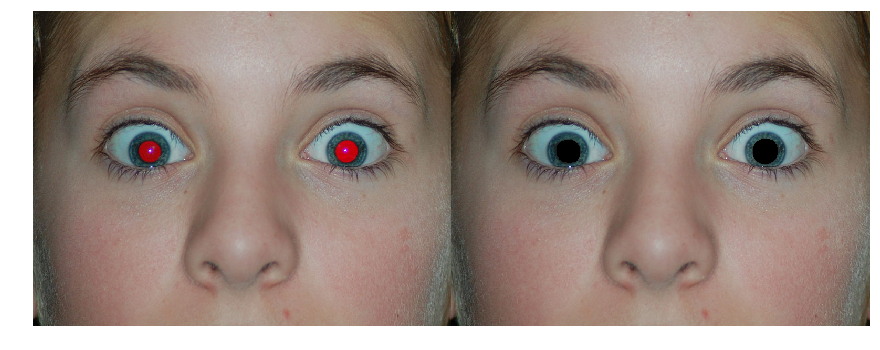

In [5]:
# Create a horizontal stack
outputImage = np.hstack([img, imgOut])
cv2.imwrite("data/images/redEyeRemoved.png",outputImage)
imshow(outputImage)
